In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import random
import time

In [22]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.mlemodel import MLEModel
import statsmodels.api as sm
from scipy import stats
import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles.collectors import Moments

# 粒子フィルタリング

## データ生成

In [3]:
def generate_test_data(m0: float, C0: float, w: float, v: float, T: int):
    """
    非線形のベンチマークモデルでデータ生成(11.4.1参照)
    Args:
        m0: 事前分布の期待値
        C0: 事前分布の分散
        W: 状態雑音
        V: 観測雑音
        T: 生成するデータ数
    """
    def benchmark_model(x, t, w, v):
        """非線形ベンチマークモデル"""
        x = 1/2 * x + (25 * x / (1 + x**2)) + 8 * math.cos(1.2 * t) + w
        y = x ** 2 / 20 + v
        return x, y

    x = np.zeros((T, 1)) 
    y = np.zeros((T, 1))
    w = np.random.normal(0, w, T)
    v = np.random.normal(0, v, T)
    x[0] = np.random.normal(m0, C0)
    _, y[0] = benchmark_model(x=x[0], t=0, w=w[0], v=v[0])
    for t in range(1, T):
        x[t], y[t] = benchmark_model(x[t-1], t, w[t], v[t])
    return x, y

In [4]:
m0 = 10
C0 = 9
w = 1 
v = 2
T = 100
x, y = generate_test_data(m0, C0, w, v, T)

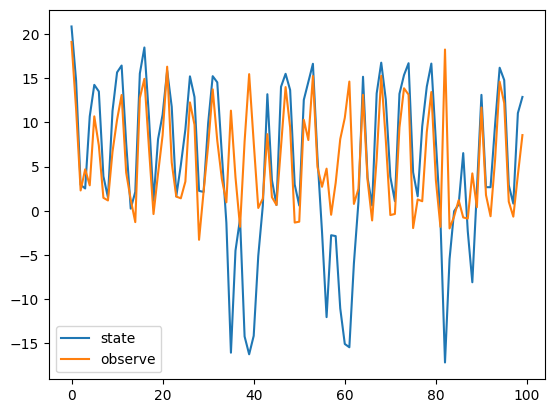

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(T), x.reshape(-1), label="state")
ax.plot(range(T), y.reshape(-1), label="observe")
ax.legend()

## カルマンフィルタ
- ローカルレベルモデルとして推定

In [6]:
def kalman_filter(m, C, y, G, F, W, V):
    """
    m: 時点t-1のフィルタリング分布の期待値
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    G: 状態遷移行列
    F: 観測行列
    W: 状態雑音
    V: 観測雑音
    """
    # 1期先予測分布
    a = G @ m
    R = G @ C @ G.T + W
    # 1期先予測尤度
    f = F @ a
    Q = F @ R @ F.T + V
    # カルマン利得
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # 状態の更新
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C

In [7]:
m = np.zeros((T, 1))
C = np.zeros((T, 1, 1))
G = np.array([[1]]) # 状態遷移行列
f = np.array([[1]]) # 観測行列
W = np.array([[w]])
V = np.array([[v]])
m[0] = m0
C[0] = C0
for t in range(1, T):
    m[t], C[t] = kalman_filter(m[t-1], C[t-1], y[t], G, f, W, V)

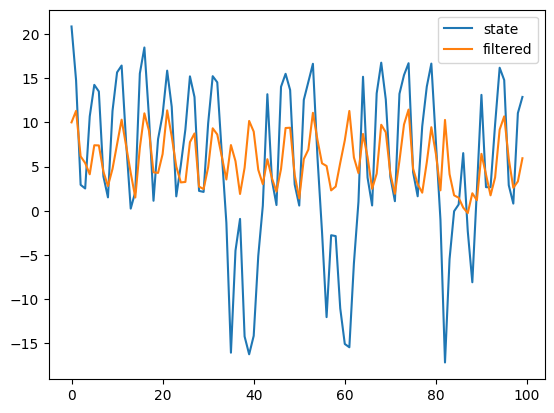

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(T), x.reshape(-1), label="state")
ax.plot(range(T), m.reshape(-1), label="filtered")
ax.legend()

## 自作粒子フィルタ

In [9]:
class ParticleFilter:
    def __init__(self, y, n_particle, w, v):
        self.y = y
        self.n_sample = y.shape[0]
        self.n_particle = n_particle
        self.w = w
        self.v = v

    @staticmethod
    def state_eq(x: np.ndarray, t: int) -> np.ndarray:
        """
        状態方程式
        Args:
            x: t-1時点の状態変数（粒子数×状態数）
            t: 時点
        Return:
            t時点の状態変数
        """
        return 1/2 * x + (25 * x / (1 + x**2)) + 8 * math.cos(1.2 * t) 
    
    def sampling_from_proposed_distribution(self, x: np.ndarray, t: int) -> np.ndarray:
        """
        提案分布から状態変数をサンプリングする．
        Args:
            x: t-1時点の状態変数（粒子数×状態数）
            t: 時点
        Return:
            t時点の状態変数
        """
        # W = self.w * np.eye(x.shape[0])
        # x = np.random.multivariate_normal(self.state_eq(x, t).flatten(), W)
        # return x.reshape(-1, 1)
        for i in range(x.shape[0]):
            x[i] = np.random.normal(self.state_eq(x[i], t), w)
        return x

    @staticmethod
    def observe_eq(x):
        """観測方程式"""
        return x ** 2 / 20

    def update_weights(self, x: np.ndarray, weights: np.ndarray, y: np.ndarray):
        """
        尤度によって重みを更新 ＆ 規格化
        Args:
            x: 粒子の状態の配列（粒子数×状態数）
            weights: 粒子の重みの配列（粒子数）
            y: 観測値（状態数）
        """
        likelihoods = stats.norm.pdf(y, loc=self.observe_eq(x), scale=self.v)
        weights = np.dot(weights, likelihoods)
        weights = weights / sum(weights) 
        return weights

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1

    def resampling(self, x, weights):
        """
        更新された重みに従い，xを復元抽出する
        Args:
            x: 粒子の状態の配列
            weights: 粒子の重みの配列
        """
        idx = np.asanyarray(range(self.n_particle)) 
        k_array = np.zeros(self.n_particle, dtype=np.int32)
        w_cumsum = np.cumsum(weights)

        for i, u in enumerate(np.random.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_array[i] = k
        x = x[k_array]
        return x
    
    def sampling(self):
        x = np.zeros((self.n_sample, self.n_particle, 1)) 
        
        for t in range(1, self.n_sample):
            weights = (1 / n_particle) * np.ones((self.n_particle))
            # 提案分布からサンプリング
            x[t] = self.sampling_from_proposed_distribution(x[t-1], t)  
            # 重みを更新
            weights = self.update_weights(x[t], weights, self.y[t])
            # リサンプリング
            x[t] = self.resampling(x[t], weights)
        return x

In [10]:
n_particle = 10000
pf = ParticleFilter(y, n_particle, w, v)

In [11]:
%%time
filtered_x = pf.sampling()

CPU times: user 28.6 s, sys: 60.6 ms, total: 28.7 s
Wall time: 28.6 s


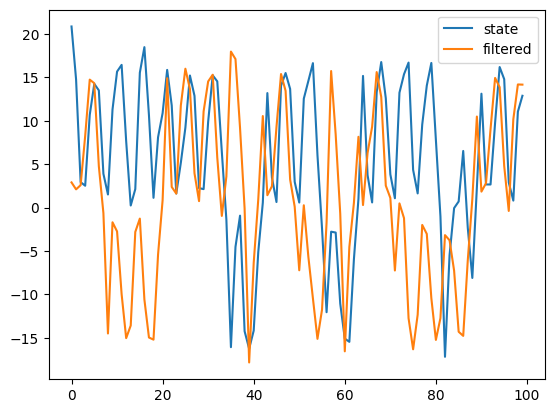

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(T), x.reshape(-1), label="state")
ax.plot(range(T), np.mean(filtered_x, axis=1).reshape(-1), label="filtered")
ax.legend()

## パッケージ粒子フィルタ

In [31]:
class BenchmarkModel(ssm.StateSpaceModel):
    # X_0の初期分布    
    def PX0(self):
        return dists.Normal(loc=self.m0, scale=self.w0)
        
    # X_t|X_{t-1}の分布
    def PX(self, t, xp):
        mu = 1/2 * xp + (25 * xp / (1 + xp**2)) + 8 * math.cos(1.2 * t)
        return dists.Normal(loc=mu, scale=self.w)
        
    # Y_t|X_tの分布
    def PY(self, t, xp, x):
        mu = x**2 / 20
        return dists.Normal(loc=mu, scale=self.v)

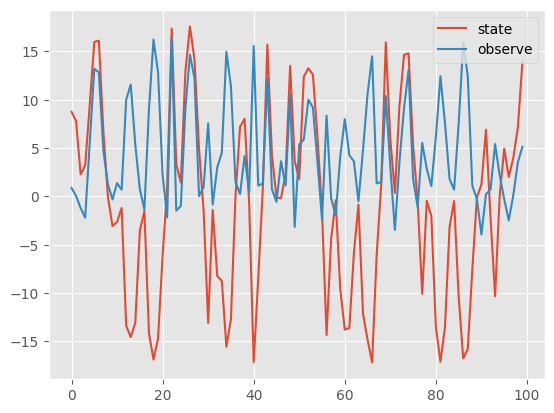

In [36]:
T =100
bm_model = BenchmarkModel(m0=10, w0=9, w=1, v=2) 
true_states, data = bm_model.simulate(T) 

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(T), true_states, label="state")
ax.plot(range(T), data, label="observe")
ax.legend()

In [37]:
fk_my_sv = ssm.Bootstrap(ssm=bm_model, data=y) # 状態空間モデルをFeynmanbootstrapフィルターを適用する
alg = particles.SMC(fk=fk_my_sv, N=T, collect=[Moments()]) # SMCオブジェクトを作成
alg.run() # アルゴリズムをT期まで実行

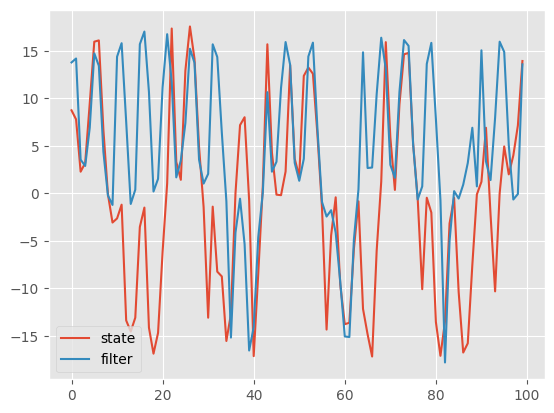

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(T), true_states, label="state")
ax.plot(range(T), [m['mean'] for m in alg.summaries.moments], label="filter")
ax.legend()